Plan
- Introduction to task, explain the data sources ect., how product strategy contributes to larger strategic goals- purpose behind work
- Get data in a SQLite database- shows scalability 
- Perform EDA, create visulisations of data, identify any bias 
- 

Strategic Aims of campaign:
- Find option which has the highest success of converting users to Gold membership- therefore helping to incrase profits, and Gold members are more likely to find love so aligns with Muzz's mission 

In [1]:
#import required packages 
import pandas as pd 
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.power import TTestIndPower
import scipy.stats as stats

In [2]:
#read in data 
impressions = pd.read_csv('impressions.csv')
transactions = pd.read_csv('transactions.csv')
user_variants = pd.read_csv('user_experiment_variants.csv')

In [3]:
impressions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165531 entries, 0 to 165530
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   memberID      165531 non-null  int64 
 1   impressionID  165531 non-null  object
 2   timestamp     165531 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   memberID   319 non-null    int64  
 1   timestamp  319 non-null    object 
 2   priceGBP   319 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.6+ KB


In [5]:
user_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613910 entries, 0 to 613909
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   memberID       613910 non-null  int64 
 1   variant        613910 non-null  object
 2   enteredTestAt  613910 non-null  object
dtypes: int64(1), object(2)
memory usage: 14.1+ MB


In [6]:
##check for duplicate values

print(f"Duplicates in Impressions Dataset is:{impressions.duplicated().sum()},({100*impressions.duplicated().sum()/len(impressions)})%")
print(f"Duplicates in Transactions Dataset is:{transactions.duplicated().sum()},({100*transactions.duplicated().sum()/len(transactions)})%")
print(f"Duplicates in User impressions Dataset is:{user_variants.duplicated().sum()},({100*user_variants.duplicated().sum()/len(user_variants)})%")

Duplicates in Impressions Dataset is:0,(0.0)%
Duplicates in Transactions Dataset is:0,(0.0)%
Duplicates in User impressions Dataset is:0,(0.0)%


In [7]:
print("cardinality of variables in impressions datasets is:")
print(impressions.nunique())
print('Length of impressions df: ', len(impressions.index))
print("\n","-"*70)
print("\nCardinality of varaibles in transactions datsets is:")
print(transactions.nunique())
print('Length of transactions df: ', len(transactions.index))
print("\n","-"*70)
print("\nCardinality of variables in user experiments datsets is:")
print(user_variants.nunique())
print('Length of user experiments df: ', len(user_variants.index))

cardinality of variables in impressions datasets is:
memberID         46777
impressionID    128707
timestamp       138719
dtype: int64
Length of impressions df:  165531

 ----------------------------------------------------------------------

Cardinality of varaibles in transactions datsets is:
memberID     319
timestamp    319
priceGBP       1
dtype: int64
Length of transactions df:  319

 ----------------------------------------------------------------------

Cardinality of variables in user experiments datsets is:
memberID         613910
variant               3
enteredTestAt    613904
dtype: int64
Length of user experiments df:  613910


In [16]:
# Establish a connection to the database
conn = sqlite3.connect('database.db')

# Create a cursor object
cursor = conn.cursor()

# Define SQL queries to create tables
create_impressions_table = '''CREATE TABLE IF NOT EXISTS impressions (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    memberID INTEGER ,
    impressionID TEXT ,
    timestamp TEXT
)'''

create_transactions_table = '''CREATE TABLE IF NOT EXISTS transactions (
    memberID INTEGER PRIMARY KEY,
    timestamp TEXT,
    priceGBP TEXT
)'''

create_user_experiment_variants_table = '''CREATE TABLE IF NOT EXISTS user_experiment_variants (
    memberID INTEGER PRIMARY KEY,
    variant TEXT,
    enteredTestAt TEXT
)'''

# Execute the SQL queries
cursor.execute(create_transactions_table)
cursor.execute(create_impressions_table)
cursor.execute(create_user_experiment_variants_table)

# Commit the changes
conn.commit()

# Read and insert data from 'impressions.csv'
with open('impressions.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        cursor.execute('INSERT INTO impressions (memberID, impressionID, timestamp) VALUES (?, ?, ?)', row)


# Read and insert data from 'transactions.csv'
with open('transactions.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        cursor.execute('INSERT INTO transactions (memberID, timestamp, priceGBP) VALUES (?, ?, ?)', row)


# Read and insert data from 'user_experiment_variants.csv'
with open('user_experiment_variants.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        cursor.execute('INSERT INTO user_experiment_variants (memberID, variant, enteredTestAt) VALUES (?, ?, ?)', row)

# Commit the changes
conn.commit()

# Close the cursor and the connection
cursor.close()
conn.close()

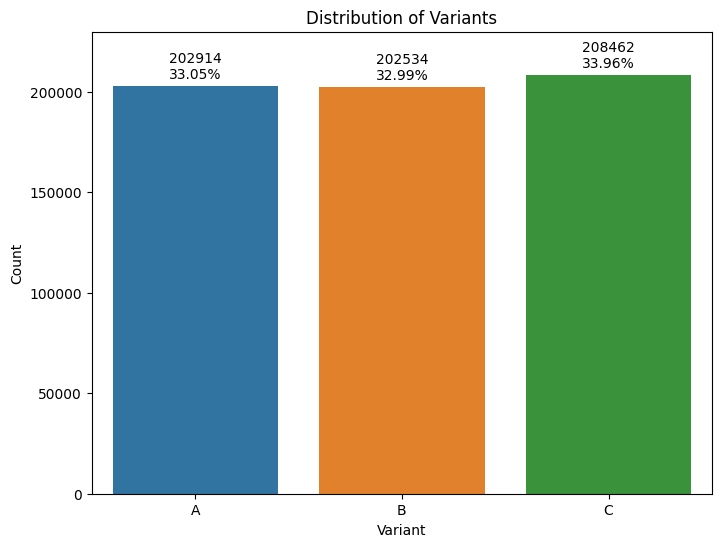

In [9]:
# Sort the DataFrame by 'variant' column
user_variants_sorted = user_variants.sort_values('variant')

# Calculate total count
total_count = len(user_variants_sorted)

# Plotting the countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='variant', data=user_variants_sorted)
plt.title('Distribution of Variants')
plt.xlabel('Variant')
plt.ylabel('Count')

# Adding value counts and ratio to the bars
for p in ax.patches:
    height = p.get_height()
    count_ratio = height / total_count * 100
    ax.annotate(f'{height}\n{count_ratio:.2f}%',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Adjusting the y-axis limits
plt.ylim(top=ax.get_ylim()[1] * 1.05)  # Increase the y-axis limit by 10%

# Display the chart
plt.show()

Conduct power analysis 

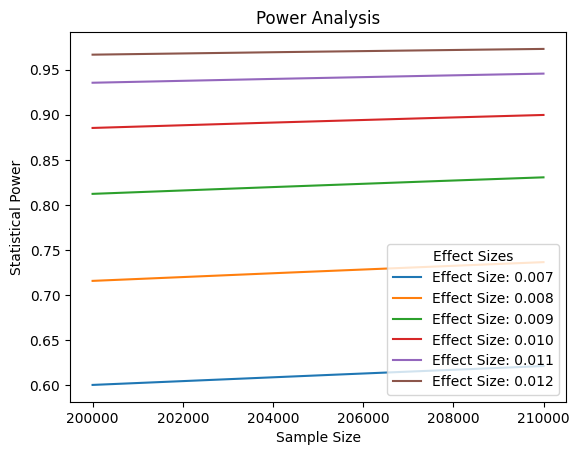

In [10]:
# Power analysis varying parameters
effect_sizes = np.array([0.007,0.008, 0.009, 0.01, 0.011, 0.012])
sample_sizes = np.array(range(200000, 210000))

# Plot power curves
obj = TTestIndPower()
fig, ax = plt.subplots()
for effect_size in effect_sizes:
    power = obj.power(effect_size=effect_size, nobs1=sample_sizes, alpha=0.05)
    label = f"Effect Size: {effect_size:.3f}"
    ax.plot(sample_sizes, power, label=label)

# Customize the legend to show unrounded effect sizes
ax.legend(title='Effect Sizes', loc='lower right')
plt.gca().get_legend().get_title().set_fontsize('10')  # Adjust legend title font size

# Label the axes
plt.xlabel('Sample Size')
plt.ylabel('Statistical Power')

# Add a title
plt.title('Power Analysis')

# Display the plot
plt.show()



Calculating metrics

In [17]:
conn = sqlite3.connect('database.db')
cursor = conn.cursor()

create_table_query = '''
CREATE TABLE conversion_rate (
    memberID INTEGER PRIMARY KEY,
    variant TEXT,
    timestamp TEXT,
    enteredTestAt TEXT
);
INSERT INTO conversion_rate (memberID, variant, timestamp, enteredTestAt)
SELECT transactions.memberID, user_experiment_variants.variant, transactions.timestamp, user_experiment_variants.enteredTestAt
FROM user_experiment_variants
LEFT JOIN transactions ON transactions.memberID = user_experiment_variants.memberID;
'''
cursor.executescript(create_table_query)

conn.commit()
conn.close()

In [28]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
df = pd.read_sql_query('SELECT * FROM conversion_rate', conn)
df['converted'] = df['timestamp'].notna().astype(int)
df.to_sql('conversion_rate', conn, if_exists='replace', index=False)
conn.commit()
conn.close()


In [29]:
conn = sqlite3.connect('database.db')

# Execute the query and load the result into a DataFrame
df_conversion_rate = pd.read_sql_query("SELECT * FROM conversion_rate", conn)

conn.close()

In [20]:
#calculate conversion rate 

variant_count = df_conversion_rate['variant'].value_counts()
variant_with_timestamp_count = df_conversion_rate[df_conversion_rate['timestamp'].notna()]['variant'].value_counts()
percentage_with_timestamp = (variant_with_timestamp_count / variant_count) * 100
print(percentage_with_timestamp)

A    0.050268
B    0.058262
C    0.046531
Name: variant, dtype: float64


In [36]:
# Calculate the conversion rate for each version
conversion_rates = df_conversion_rate.groupby('variant')['converted'].mean()*100

# Calculate the total number of conversions and total sample size for each version
total_conversions = df_conversion_rate.groupby('variant')['converted'].sum()
total_samples = df_conversion_rate.groupby('variant')['converted'].count()

# Calculate the overall conversion rate
overall_conversion_rate = df_conversion_rate['converted'].mean()


In [42]:
import numpy as np
from scipy.stats import chi2_contingency

# Define the observed frequencies
observed = np.array([[102, 202812], [118, 202416], [97, 208365]])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

# Print the results
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)

Chi-square statistic: 2.8490232418671195
Degrees of freedom: 2
P-value: 0.24062595119407593


In [43]:
import statsmodels.api as sm
import pandas as pd

logistic_df= df_conversion_rate[['variant','converted']]

# Convert the predictor variable into dummy/indicator variables
data = pd.get_dummies(logistic_df, columns=['variant'], drop_first=True)

# Split the data into predictor (X) and outcome (y) variables
X = data.drop('converted', axis=1)
y = data['converted']

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the logistic regression model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.004422
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               613910
Model:                          Logit   Df Residuals:                   613907
Method:                           MLE   Df Model:                            2
Date:                Sat, 08 Jul 2023   Pseudo R-squ.:               0.0005185
Time:                        17:14:55   Log-Likelihood:                -2714.8
converged:                       True   LL-Null:                       -2716.2
Covariance Type:            nonrobust   LLR p-value:                    0.2445
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5951      0.099    -76.687      0.000      -7.789      -7.401
variant_B      0.1477      0

In [48]:
odds_ratios = np.exp(result.params)
print(odds_ratios)

Intercept       0.000503
variant[T.B]    1.159126
variant[T.C]    0.925636
dtype: float64


B has highest conversion rate however this is not statistically significant compared to the other groups so little confidence that the different variation have any effect 

Need to consider if conversion rate is worth it-- will it increase profits ?

Do i want to consider other metrics e.g. mean time between impression and transaction 

Need to visualise the distribution of time - this could be an idea for further experimentation 

In [50]:
df_conversion_rate.dtypes

memberID          int64
variant          object
timestamp        object
enteredTestAt    object
converted         int64
dtype: object

In [51]:
df_conversion_rate['timestamp'] = pd.to_datetime(df['timestamp'])
df_conversion_rate['enteredTestAt'] = pd.to_datetime(df['enteredTestAt'])

In [52]:
df_conversion_rate.dtypes

memberID                  int64
variant                  object
timestamp        datetime64[ns]
enteredTestAt    datetime64[ns]
converted                 int64
dtype: object

In [77]:
df_conversion_rate['sec_diff'] = (df_conversion_rate['timestamp'] - df_conversion_rate['enteredTestAt']).dt.total_seconds()

In [59]:
# Calculate the mean time for each category
mean_time = df_conversion_rate.groupby('variant')['sec_diff'].mean()

print(mean_time)

variant
A    521432.018713
B    522015.842047
C    436557.517154
Name: sec_diff, dtype: float64


In [78]:
df_converted = df_conversion_rate.dropna()

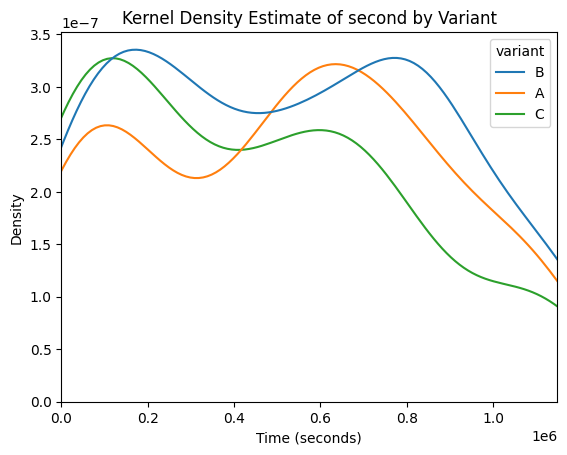

In [72]:
sns.kdeplot(data=df_converted, x='sec_diff', hue='variant')

# Set x-axis limits
plt.xlim(0, df_conversion_rate['sec_diff'].max())

# Set labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of second by Variant')

# Show the plot
plt.show()

Shapiro-Wilk test for A
Test statistic: 0.9373729825019836
p-value: 0.00011412601452320814

Shapiro-Wilk test for B
Test statistic: 0.9376966953277588
p-value: 3.487836875137873e-05

Shapiro-Wilk test for C
Test statistic: 0.9189198613166809
p-value: 1.6305861208820716e-05



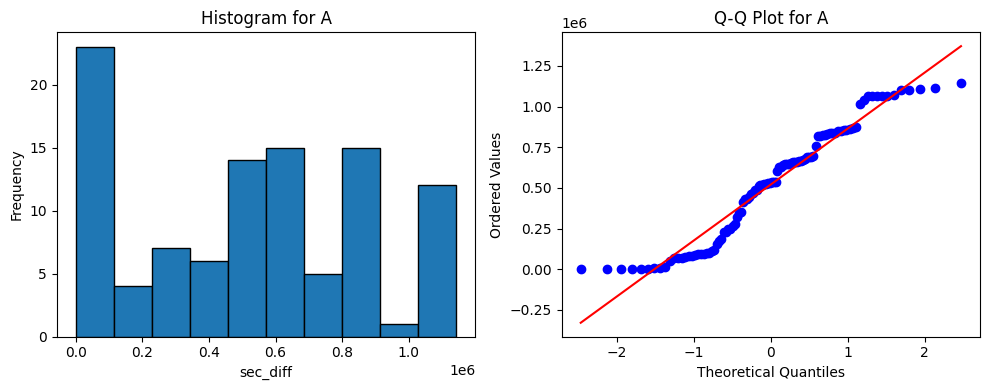

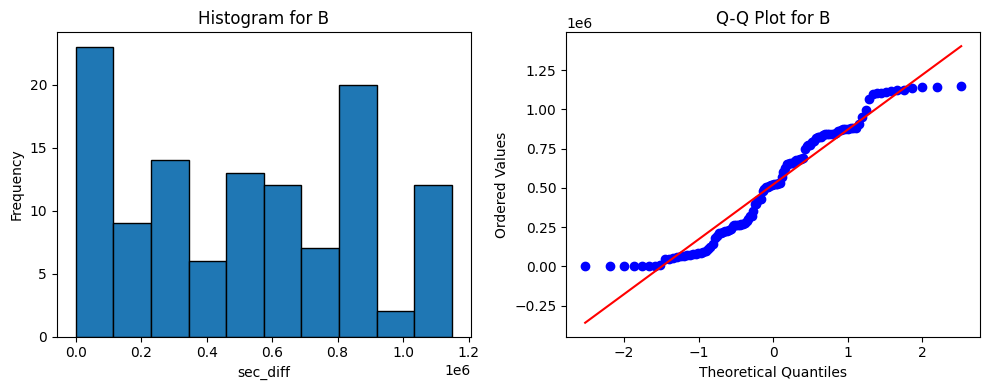

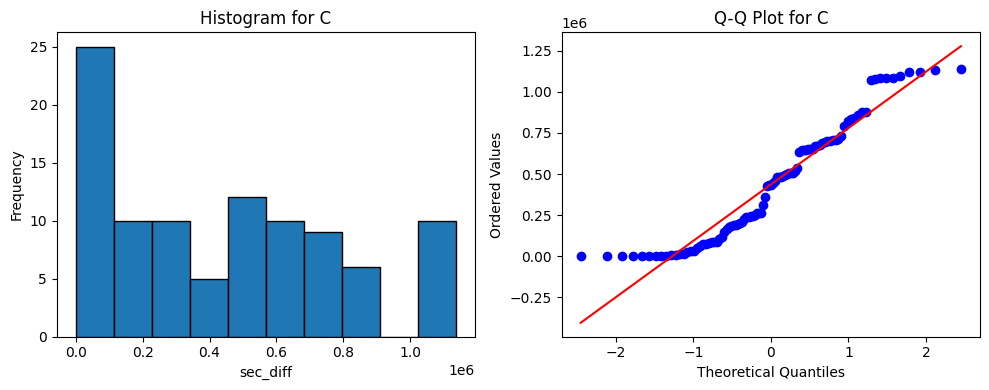

In [80]:
# Group the data by the 'variant' column
grouped_data = df_converted.groupby('variant')['sec_diff']

# Perform Shapiro-Wilk test for each group
for group, data in grouped_data:
    print("Shapiro-Wilk test for", group)
    statistic, p_value = stats.shapiro(data)
    print("Test statistic:", statistic)
    print("p-value:", p_value)
    print("")

# Create histograms and Q-Q plots for each group
for group, data in grouped_data:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Histogram
    axes[0].hist(data, bins=10, edgecolor='black')
    axes[0].set_title('Histogram for ' + group)
    axes[0].set_xlabel('sec_diff')
    axes[0].set_ylabel('Frequency')
    
    # Q-Q plot
    stats.probplot(data, dist='norm', plot=axes[1])
    axes[1].set_title('Q-Q Plot for ' + group)
    axes[1].set_xlabel('Theoretical Quantiles')
    axes[1].set_ylabel('Ordered Values')
    
    plt.tight_layout()
    plt.show()



In [81]:
 #Extract the values for each group
data = [grouped_data.get_group('A').values,
        grouped_data.get_group('B').values,
        grouped_data.get_group('C').values]

# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(*data)

# Print the results
print("Kruskal-Wallis test results:")
print("Test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test results:
Test statistic: 4.483303447898152
p-value: 0.1062828094576858
